In [12]:
import sys, os
from polychrom import forcekits, forces, starting_conformations, simulation
from polychrom.hdf5_format import HDF5Reporter
import numpy as np
import openmm as mm
from dataclasses import dataclass
from math import pi
from typing import Dict, List, Tuple, TypedDict, Any
import pickle
import numpy as np
import simtk.unit
mm.Platform.loadPluginsFromDirectory(mm.Platform.getDefaultPluginsDirectory())



()

In [ ]:
def attractiveBondForce(
    sim_object: simulation.Simulation,
    bonds: list[tuple[int, int]],
    strength_kt: float = 2,
    cutoff: float = 2.0,
    name: str = "attr_bonds",
) -> mm.CustomBondForce:
    """
    Attractive bond force that mimics the nonbonded potential.
    (it is based on the polynomial repulsive force, just negative of it)
    A workaround to enable a simple short-range attraction between just these two monomers.
    """

    energy = (
        "- step(ATTRsigma - r) * eattr;"
        "eattr = rsc12 * (rsc2 - 1.0) * ATTRe / emin12 + ATTRe;"
        "rsc12 = rsc4 * rsc4 * rsc4;"
        "rsc4 = rsc2 * rsc2;"
        "rsc2 = rsc * rsc;"
        "rsc = r / ATTRsigma * rmin12;"
    )

    force = mm.CustomBondForce(energy)
    force.name = name  # type: ignore

    force.addGlobalParameter("ATTRsigma", sim_object.conlen * cutoff)
    force.addGlobalParameter("ATTRe", sim_object.kT * strength_kt)
    force.addGlobalParameter("emin12", 46656.0 / 823543.0)
    force.addGlobalParameter("rmin12", np.sqrt(6.0 / 7.0))    

    for (i, j) in bonds:
        force.addBond(int(i), int(j), [])

    return force

In [13]:
from poly_shared import (
    MoleculeStructure,
    Bond,
    Angle,
    Dihedral,
    dihedral_angle,
    verify_bond_angle_dihedral_uniqeness,
    concatenate_molecule_structures,
    build_ribbon,
    connect_ribbon_ends,
    connect_with_polymer,
    add_polymer_forces,
    build_hairy_ring,
    build_line_attached_to_monomer,
    threeWayAttraction,
    add_fucking_complicated_force, 
    MoleculeStructureCollection
)

In [43]:
def find_minimum_triplet_distance(
    pos: np.ndarray, type1_indices: list[int], type2_indices: list[int], type3_indices: list[int], cutoff: float = 2.0
) -> Tuple[float, np.ndarray, int]:
    """
    Find the minimum pairwise distance across all possible triplets and return the indices of the triplet with the minimum distance.
    Also returns the number of triplets with distance < cutoff

    Parameters:
    -----------
    pos : array-like, shape (N, 3)
        Positions of all particles
    type1_indices : array-like
        Indices of type 1 particles
    type2_indices : array-like
        Indices of type 2 particles
    type3_indices : array-like
        Indices of type 3 particles

    Returns:
    --------
    min_distance : float
        The minimum distance found
    best_triplet : np.ndarray
        Indices (i1, i2, i3) of the triplet with minimum distance
    """
    
    # Get positions for each type
    pos1 = pos[type1_indices]  # shape: (n_type1, 3)
    pos2 = pos[type2_indices]  # shape: (n_type2, 3)
    pos3 = pos[type3_indices]  # shape: (n_type3, 3)

    min_distance = np.inf
    best_triplet = np.array((1, 1, 1))  # Initialize with dummy values

    num_triplets = 0  # Counter for triplets with distance < cutoff
    # Loop over type1 and type2 (small arrays)
    for i1, idx1 in enumerate(type1_indices):
        for i2, idx2 in enumerate(type2_indices):
            # Vectorized distance calculation for all type3
            d12 = np.linalg.norm(pos1[i1] - pos2[i2])
            d13 = np.linalg.norm(pos1[i1] - pos3, axis=1)  # vectorized over type3
            d23 = np.linalg.norm(pos2[i2] - pos3, axis=1)  # vectorized over type3

            # Minimum distance for each type3 particle with this (type1, type2) pair
            triplet_min_distances = np.maximum(d12, np.maximum(d13, d23))

            # Find the best type3 for this (type1, type2) pair
            best_i3 = np.argmin(triplet_min_distances)
            current_min = triplet_min_distances[best_i3]
            if current_min < cutoff:
                num_triplets += (triplet_min_distances < cutoff).sum()

            if current_min < min_distance:
                min_distance = current_min
                best_triplet = np.array((idx1, idx2, type3_indices[best_i3]))

    return float(min_distance), best_triplet, num_triplets



In [ ]:
extra_bonds: list[Bond] = []
extra_angles: list[Angle] = []
extra_dihedrals: list[Dihedral] = []
non_display_bonds: list[Bond] = []  # bonds that are not displayed in the visualization


extra_kw = {"extra_bonds": extra_bonds, "extra_angles": extra_angles, "extra_dihedrals": extra_dihedrals}

l_till_break = 14
n_rows = 28

shared_kwargs: dict[str, Any] = {
    "right_angle_k": 100.0,
    "backbone_angle_k": 150.0,
    "dihedral_k": 100.0,
    "n_rows": n_rows,
    "break_idx": n_rows - l_till_break,
}

d_off = 0.81

structures = MoleculeStructureCollection()

if True:  # define ribbons
    ribbon = build_ribbon(**shared_kwargs, dihedral_offset=d_off, break_sign=1.0)
    structures["ribbon1"] = ribbon
    ribbon2 = build_ribbon(
        start=(0, 3, 0),
        start_particle_index=structures.next_idx(),
        dihedral_offset=-d_off,
        break_sign=-1.0,
        **shared_kwargs
    )
    structures["ribbon2"] = ribbon2

    # does not create anything
    connect_ribbon_ends(ribbon, ribbon2, **extra_kw, last_row_length=3, penult_row_length=3.3)

    # sorry for the mess :(
    non_display_bonds.extend(extra_bonds[-4:])  # last 4 bonds are not displayed in the visualization

    # connect ribbon starts with a fixed bond, and make it perpendicular to the backbone
    sp1 = ribbon.start_particle_index
    sp2 = ribbon2.start_particle_index
    extra_bonds.append((sp1, sp2, 4.5, 0.15))
    non_display_bonds.append((sp1, sp2, 4.5, 0.15))  # this bond is not displayed in the visualization
    extra_angles.append((sp2, sp1, sp1 + 2, pi / 2, shared_kwargs["right_angle_k"]))
    extra_angles.append((sp1, sp2, sp2 + 2, pi / 2, shared_kwargs["right_angle_k"]))

USE_TWIST_DIHEDRALS = False  # whether to use dihedrals to stabilize the twisting of ribbons at the connection
# stabilize the twisting of ribbons at the connection
twist_angle = 2.1  # empirically obtained typical angle at rest
# record dihedral indices for updating them in the future
dih1 = (sp1, sp2, sp2 + 2, sp2 + 2 + 1)
dih2 = (sp2, sp1, sp1 + 2, sp1 + 2 + 1)

extra_dihedrals.append((*dih1, -twist_angle, shared_kwargs["dihedral_k"]))
extra_dihedrals.append((*dih2, twist_angle, shared_kwargs["dihedral_k"]))


# if True parts are for code folding in the notebook

if True:  # connect ribbons with polymers

    polymer = connect_with_polymer(
        ribbon,
        ribbon.get_end_idx(),
        ribbon2,
        ribbon2.get_end_idx(),
        start_mon_idx=structures.next_idx(),
        n_monomers=6,
        extra_bonds=extra_bonds,
    )
    structures["polymer1"] = polymer
    polymer2 = connect_with_polymer(
        ribbon,
        ribbon.start_particle_index,
        ribbon2,
        ribbon2.start_particle_index,
        start_mon_idx=structures.next_idx(),
        n_monomers=13,
        extra_bonds=extra_bonds,
    )
    structures["polymer2"] = polymer2

    polymer3 = connect_with_polymer(
        ribbon,
        ribbon.start_particle_index + 5,
        ribbon2,
        ribbon2.start_particle_index + 5,
        start_mon_idx=structures.next_idx(),
        n_monomers=8,
        extra_bonds=extra_bonds,
    )
    structures["polymer3"] = polymer3

if True:  # build NIPBLs and hinge sticks
    nipbl1 = build_line_attached_to_monomer(
        polymer2,
        polymer2.start_particle_index + 3,
        n_monomers=26,
        start_mon_idx=structures.next_idx(),
        bond_dl=0.05,
        extra_bonds=extra_bonds,
    )
    structures["nipbl1"] = nipbl1

    ## scrunch up the NIPBL a bit
    # for i in range(0, len(nipbl1.positions) - 6, 3):
    #    extra_bonds.append((nipbl1.start_particle_index + i, nipbl1.start_particle_index + i + 5, 0.5, 1.8))
    #    non_display_bonds.append((nipbl1.start_particle_index + i, nipbl1.start_particle_index + i + 5, 0.5, 1.8))

    hinge_stick1 = build_line_attached_to_monomer(
        polymer,
        polymer.start_particle_index + 3,
        n_monomers=4,
        start_mon_idx=structures.next_idx(),
        bond_dl=0.05,
        extra_bonds=extra_bonds,
    )
    structures["hinge_stick1"] = hinge_stick1


if True:  # build a hairy ring
    ring = build_hairy_ring(
        radius=50,
        n_monomers=420,  # a little more than 2*pi*50 because MD does not like straight lines,
        plane="XZ",
        p_hairy=0.5,
        seed=42,
        backbone_k=2.0,
        start_mon_idx=structures.next_idx(),
    )
    structures["ring"] = ring

    # ring is build in XZ plane
    # ring needs to pass through (1.5, 0, 1.5) to be in the right place
    ring.positions = ring.positions - np.array([0, 0, 50])  # shift the ring to pass through (0,0,0)
    ring.positions = ring.positions + np.array([1.5, 0, 1.5])  # shift the ring to pass through (1.5, 0, 1.5)


if True:  # define indices for three-way attraction
    # These indices will be used to find the triplet with minimum distance
    # and apply three-way attraction force to it

    # The triplet consists of:
    # - last two monomers of each hinge stick (type 1)
    # - last two monomers of each nipbl (type 2)
    # - the entire ring (type 3)

    # type 1 - last 2 monomers of each hinge stick
    type1_indices = [hinge_stick1.start_particle_index + len(hinge_stick1.positions) - 1]

    # type 2 - last 2 monomers of each nipbl
    type2_indices = [nipbl1.start_particle_index + len(nipbl1.positions) - 1]

    # type 3 indices - the entire ring
    type3_indices = list(range(ring.start_particle_index, ring.start_particle_index + len(ring.positions) - 2))

if True:  # concatenate structures, define positions, bonds, angles, dihedrals
    combined_structure = concatenate_molecule_structures(structures)

    N = combined_structure.positions.shape[0]
    positions = combined_structure.positions

    bonds = combined_structure.bonds + extra_bonds
    angles = combined_structure.angles + extra_angles
    dihedrals = combined_structure.dihedrals + extra_dihedrals


# positions = pickle.load(open("captured_try1.pkl", "rb"))
# positions = pickle.load(open("start_try1.pkl", "rb"))

reporter = HDF5Reporter(folder="trajectory", max_data_length=5, overwrite=True)
final_collision_rate = 0.01
sim = simulation.Simulation(
    platform="OpenCL",
    integrator="variableLangevin",
    error_tol=0.001,
    GPU="0",
    collision_rate=0.01,
    N=N,
    save_decimals=5,
    PBCbox=False,
    reporters=[reporter],
)


sim.set_data(positions, center=False)  # loads a polymer, puts a center of mass at zero

# Add forces to the simulation
res = add_polymer_forces(sim, bonds, angles, dihedrals)
assert res is not None  # here it won't be None as we have dihedrals
DihedralIndDict, dihedral_force = res
# sim.add_force(forces.spherical_confinement(sim, r=20, k=1))
# nonbonded force
rep_force = forces.smooth_square_well(sim, 30, 1.03, attractionEnergy=0.45, attractionRadius=1.5)
sim.add_force(rep_force)

remover = mm.CMMotionRemover()
remover.name = "remover"  # type: ignore - this is polychrom's old convention
sim.add_force(remover)  # add motion remover to remove center of mass motion

k_linear = 1.6
if True:  # add a fucking complicated force
    # --- build the CustomCompoundBondForce with “energy first” ----------------
    fuckingComplicatedForce = add_fucking_complicated_force(sim, k_linear)
    break_idx = shared_kwargs["break_idx"]
    for ribbon_use, cpl_sign, brk_sign in ((ribbon, 1, 1), (ribbon2, -1, -1)):
        # add particles in the order they are used in the expression

        particles = [ribbon_use.index_dict[(i, j)] for i in range(break_idx - 3, break_idx + 2) for j in (0, 1)]
        print(particles)
        fuckingComplicatedForce.addBond(particles, [cpl_sign, brk_sign])

    sim.add_force(fuckingComplicatedForce)

threeway_cutoff = 1.8
threeway_strength = 3.6

# add three-way attraction force
three_way_force = threeWayAttraction(
    sim,
    type1_particle_idx=type1_indices,
    type2_particle_idx=type2_indices,
    type3_particle_idx=type3_indices,
    attractionEnergy=threeway_strength,
    attractionRadius=threeway_cutoff, 
)
sim.add_force(three_way_force)

type12_bonds = [(i, j) for i in type1_indices for j in type2_indices]

# add attractive bonds between type 1 and type 2 particles
attr_force = attractiveBondForce(sim, type12_bonds, strength_kt=3.5, cutoff=3.4)
sim.add_force(attr_force)

sim.eK_critical = 3000
sim.do_block(0, save_extras={"bonds": bonds})
sim.local_energy_minimization()
sim.do_block(0, save_extras={"bonds": bonds})
sim.local_energy_minimization()
sim.do_block(0, save_extras={"bonds": bonds})
sim.local_energy_minimization()
sim.do_block(0, save_extras={"bonds": bonds})


bonds_to_save = [i for i in bonds if i not in non_display_bonds]
if len(bonds) == len(bonds_to_save):
    raise ValueError("Something went wrong, all bonds are displayed, but some should not be!")

all_dh = []
cooldown = -1
for block in range(4000):
    s_pkl = np.frombuffer(pickle.dumps(structures), dtype=np.uint8)
    do_print = block % 20 == 0
    sim.do_block(
        10 * block if block < 50 else 1000,
        save_extras={"bonds": bonds_to_save, "structures": s_pkl},
        print_messages=do_print,
    )
    if block == 50:  # re-set collision rate to the final value
        sim.collisionRate = final_collision_rate * (1 / simtk.unit.picosecond)  # type: ignore
        sim.integrator.setFriction(sim.collisionRate)  # type: ignore

    pos = sim.get_data()

    # Calculating twist dihedrals and distance for statistics on that
    dh1 = dihedral_angle(pos, sp1, sp2, sp2 + 2, sp2 + 2 + 1)
    dh2 = dihedral_angle(pos, sp2, sp1, sp1 + 2, sp1 + 2 + 1)
    dist = np.sum((pos[ribbon.start_particle_index] - pos[ribbon.get_end_idx()]) ** 2)
    # print(f"Block {block}: dihedral angles {dh1:.2f}, {dh2:.2f}, distance {dist:.2f}")
    all_dh.append((dh1, dh2, dist))

    triplet_dist, _, num_triplets = find_minimum_triplet_distance(
        pos, type1_indices, type2_indices, type3_indices, threeway_cutoff
    )

    type12_dist = np.linalg.norm(pos[type1_indices][:, None, :] - pos[type2_indices][None, :, :], axis=-1).min()

    # turning dihedrals "on" upon the distance becoming small enough
    if triplet_dist < threeway_cutoff * 0.8 and not USE_TWIST_DIHEDRALS:
        if cooldown == -1:  # if cooldown is not set
            cooldown = 10  # set cooldown to 10 blocks
        if cooldown == 0:
            USE_TWIST_DIHEDRALS = True
            twist_angle = 2.1  # reset twist angle to the initial value
            print("Turning on twist dihedrals")
            cooldown = -1  # reset cooldown

    if triplet_dist > threeway_cutoff * 1.3 and USE_TWIST_DIHEDRALS:
        if cooldown == -1:
            cooldown = 10  # set cooldown to 10 blocks
        if cooldown == 0:
            USE_TWIST_DIHEDRALS = False
            twist_angle = 0.0  # reset twist angle to 0
            print("Turning off twist dihedrals")
            cooldown = -1  # reset cooldown
    cooldown -= 1
    if cooldown < -1:
        cooldown = -1

    print("\r", end="")
    print(triplet_dist, num_triplets, type12_dist, cooldown, USE_TWIST_DIHEDRALS, end="; ")

    # updating dihedrals
    ind1 = DihedralIndDict[dih1]
    ind2 = DihedralIndDict[dih2]
    if USE_TWIST_DIHEDRALS:
        twist_angle = max(twist_angle - 0.03, 0)

        dihedral_force.setTorsionParameters(ind1, *dih1, (-twist_angle, shared_kwargs["dihedral_k"]))
        dihedral_force.setTorsionParameters(ind2, *dih2, (twist_angle, shared_kwargs["dihedral_k"]))
        dihedral_force.updateParametersInContext(sim.context)  # update the parameters in the context
    else:  # basically invalidate the dihedrals, so that they do not affect the simulation
        dihedral_force.setTorsionParameters(ind1, *dih1, (-twist_angle, shared_kwargs["dihedral_k"] / 1000))
        dihedral_force.setTorsionParameters(ind2, *dih2, (twist_angle, shared_kwargs["dihedral_k"] / 1000))
        dihedral_force.updateParametersInContext(sim.context)  # update the parameters in the context


sim.print_stats()  # In the end, print very simple statistics

reporter.dump_data()  # always need to run in the end to dump the block cache to the disk

INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force dihedral_force 2
INFO:root:adding force smooth_square_well 3
INFO:root:adding force remover 4
INFO:root:adding force fuckingComplicatedForce 5
INFO:root:adding force three_way_attraction 6
INFO:root:adding force attr_bonds 7


[22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[78, 79, 80, 81, 82, 83, 84, 85, 86, 87]


INFO:root:Particles loaded. Potential energy is 47.125957
INFO:root:block    0 pos[1]=[1.0 0.0 -0.0] dr=0.00 t=0.0ps kin=1.46 pot=47.13 Rg=51.159 SPS=0 dt=0.0fs dx=0.00pm 
INFO:root:Performing local energy minimization
INFO:root:before minimization eK=1.463603358855893, eP=47.12595685131153, time=0.0 ps


In [ ]:


type12_dist

array([[2.2808888, 2.0730212],
       [1.0543247, 1.3978915],
       [1.4383216, 1.0305073]], dtype=float32)

In [ ]:
cooldown

-278

In [ ]:
dh = np.array(all_dh)
np.mean(dh, axis=0)  # mean dihedral angles

array([-7.7604508e-01,  2.3188667e-01,  3.1667053e+02], dtype=float32)

/var/folders/k4/87l5bsb52hd3_hjmy15klwch0000gn/T/ipykernel_95343/2082252021.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(dh[:, 0], dh[:, 2], s=1,  cmap="viridis")


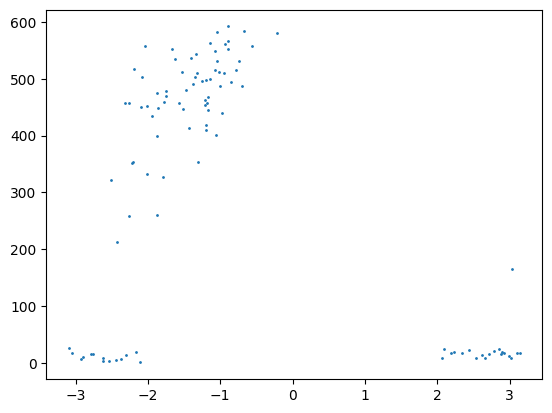

In [ ]:

import matplotlib.pyplot as plt
plt.figure() 
plt.scatter(dh[:, 0], dh[:, 2], s=1,  cmap="viridis")

In [ ]:
pos1 = pos[type1_indices]  # shape: (n_type1, 3)
pos2 = pos[type2_indices]  # shape: (n_type2, 3)
pos3 = pos[type3_indices]  # shape: (n_type3, 3)

min_distance = np.inf
best_triplet = np.array((1, 1, 1))  # Initialize with dummy values

# Loop over type1 and type2 (small arrays)
for i1, idx1 in enumerate(type1_indices):
    for i2, idx2 in enumerate(type2_indices):
        # Vectorized distance calculation for all type3
        d12 = np.linalg.norm(pos1[i1] - pos2[i2])        
        d13 = np.linalg.norm(pos1[i1] - pos3, axis=1)  # vectorized over type3
        d23 = np.linalg.norm(pos2[i2] - pos3, axis=1)  # vectorized over type3

        # Maximum distance for each type3 particle with this (type1, type2) pair
        triplet_min_distances = np.maximum(d12, np.maximum(d13, d23))

        # Find the best type3 for this (type1, type2) pair
        best_i3 = np.argmin(triplet_min_distances)
        current_min = triplet_min_distances[best_i3]

        if current_min < min_distance:
            min_distance = current_min
            best_triplet = np.array((idx1, idx2, type3_indices[best_i3]))


min_distance

np.float32(0.055478718)

In [ ]:
dh1, dh2

(np.float32(-0.6645851), np.float32(-2.4804385))

In [ ]:
pos3

array([[ 1.134292  , -1.6389232 , -3.5680275 ],
       [ 0.66645527, -1.3313147 , -2.6322765 ],
       [ 1.1246809 , -1.0164275 , -1.7853986 ],
       ...,
       [ 4.3799076 , -0.9004721 , -7.290464  ],
       [ 3.9307663 , -4.2333055 , -7.061165  ],
       [ 2.6243167 , -1.1796937 , -5.3801694 ]],
      shape=(630, 3), dtype=float32)